## LDA USA WORDS_NOUN

In [1]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from collections import Counter

import ast
import gensim
import gensim.corpora as corpora
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
from nltk.corpus import stopwords
import re

In [2]:
df = pd.read_csv("../../sentiment_labelled_usa_NB.csv")
df

,Unnamed: 0,index,Text,new_text,languages,new_text_after_translation,pos_tagged_words,words_processed_all,words_processed_noun_adj_verb_adv,words_processed_noun,text_type,sentiment
0,0,0,want find way end racism try force people inje...,want find way end racism try force people inje...,ENGLISH,want find way end racism try force people inje...,"[('want', 'JJ'), ('find', 'VB'), ('way', 'NN')...","['want', 'find', 'way', 'end', 'racism', 'try'...","['want', 'find', 'way', 'end', 'racism', 'try'...","['way', 'end', 'racism', 'force', 'people', 'b...",subjective,2
1,1,1,"this child almost died tetanus, spent months h...","this child almost died tetanus, spent months h...",ENGLISH,"this child almost died tetanus, spent months h...","[('this', 'DT'), ('child', 'NN'), ('almost', '...","['child', 'almost', 'died', 'tetanus', 'spent'...","['child', 'almost', 'die', 'tetanus', 'spend',...","['child', 'tetanus', 'month', 'hospital', 'cos...",subjective,0
2,2,2,juste se rappeler m. leblanc la pression que l...,juste se rappeler m. leblanc la pression que l...,FRENCH,just remember mr. leblanc the pressure that th...,"[('just', 'RB'), ('remember', 'VB'), ('my', 'P...","['remember', 'leblanc', 'pressure', 'provincia...","['remember', 'leblanc', 'pressure', 'provincia...","['leblanc', 'pressure', 'business', 'world', '...",subjective,0
3,3,3,"you would expect cases rise significantly, cou...","you would expect cases rise significantly, cou...",ENGLISH,"you would expect cases rise significantly, cou...","[('you', 'PRP'), ('would', 'MD'), ('expect', '...","['would', 'expect', 'case', 'rise', 'significa...","['would', 'expect', 'case', 'rise', 'significa...","['case', 'vaccination', 'rate', 'play', 'space...",subjective,2
4,4,4,depends whether vaccination status is embedded...,depends whether vaccination status is embedded...,ENGLISH,depends whether vaccination status is embedded...,"[('depends', 'VBZ'), ('whether', 'IN'), ('vacc...","['depends', 'whether', 'vaccination', 'status'...","['depend', 'vaccination', 'status', 'embed', '...","['vaccination', 'status', 'code', 'link', 'con...",subjective,2
...,...,...,...,...,...,...,...,...,...,...,...,...
320117,404255,404255,pretty remarkable achievement. thank you all v...,pretty remarkable achievement. thank you all v...,ENGLISH,pretty remarkable achievement. thank you all v...,"[('pretty', 'RB'), ('remarkable', 'JJ'), ('ach...","['pretty', 'remarkable', 'achievement', 'thank...","['pretty', 'remarkable', 'achievement', 'thank...","['achievement', 'volunteer', 'shotsshotsshot',...",subjective,2
320118,404258,404258,oh that explains similar - seemingly out nowhe...,oh that explains similar - seemingly out nowhe...,ENGLISH,oh that explains similar - seemingly out nowhe...,"[('oh', 'UH'), ('that', 'DT'), ('explains', 'V...","['explains', 'similar', 'seemingly', 'nowhere'...","['explain', 'similar', 'seemingly', 'nowhere',...","['message', 'background', 'folk', 'vaccinesave...",subjective,0
320119,404260,404260,do it others.... 💪🎉💉🤙 #vaccinesaveslives,do it others.... flexed_bicepsparty_poppersyri...,ENGLISH,do it others.... flexed_bicepsparty_poppersyri...,"[('do', 'VB'), ('it', 'PRP'), ('others', 'NNS'...","['others', 'vaccinesaveslives']","['other', 'vaccinesaveslive']","['other', 'vaccinesaveslive']",subjective,2
320120,404262,404262,yay 🙌🏻 congrats dr. j being fully vaccinated i...,yay raising_handslight_skin_tone congrats dr. ...,ENGLISH,yay raising_handslight_skin_tone congrats dr. ...,"[('yay', 'NN'), ('congrats', 'NNS'), ('do', 'V...","['yay', 'congrats', 'fully', 'vaccinated', 'be...","['congrat', 'fully', 'vaccinate', 'good', 'fee...","['congrat', 'feeling', 'safetyfirst', 'vaccine...",subjective,2


In [3]:
df.drop(columns = ['Unnamed: 0', 'index', 'Text', 'index', 'new_text', 'languages', 'new_text_after_translation', 'pos_tagged_words'], inplace = True)
df.head()

,words_processed_all,words_processed_noun_adj_verb_adv,words_processed_noun,text_type,sentiment
0,"['want', 'find', 'way', 'end', 'racism', 'try'...","['want', 'find', 'way', 'end', 'racism', 'try'...","['way', 'end', 'racism', 'force', 'people', 'b...",subjective,2
1,"['child', 'almost', 'died', 'tetanus', 'spent'...","['child', 'almost', 'die', 'tetanus', 'spend',...","['child', 'tetanus', 'month', 'hospital', 'cos...",subjective,0
2,"['remember', 'leblanc', 'pressure', 'provincia...","['remember', 'leblanc', 'pressure', 'provincia...","['leblanc', 'pressure', 'business', 'world', '...",subjective,0
3,"['would', 'expect', 'case', 'rise', 'significa...","['would', 'expect', 'case', 'rise', 'significa...","['case', 'vaccination', 'rate', 'play', 'space...",subjective,2
4,"['depends', 'whether', 'vaccination', 'status'...","['depend', 'vaccination', 'status', 'embed', '...","['vaccination', 'status', 'code', 'link', 'con...",subjective,2


In [4]:
df.info() # no empty rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320122 entries, 0 to 320121
Data columns (total 5 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   words_processed_all                320122 non-null  object
 1   words_processed_noun_adj_verb_adv  320122 non-null  object
 2   words_processed_noun               320122 non-null  object
 3   text_type                          320122 non-null  object
 4   sentiment                          320122 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


In [5]:
# load all functions

from itertools import combinations

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [13]:
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')

stop_list = stopwords.words('english')
stop_list.remove("not")
stop_list.remove("do")
stop_list.remove("we")
stop_list.remove("other")

stop_words = ['vaccine','people','couid', 'lot', 'thing', 'amp', 'day', 'week', 'time', 'year', 'vaccination',
             'month', 'number', 'part', 'hour', 'shit', 'person', 'go', 'pfizer','room', 'man', 'word', 'other', 
              'point', 'today', 'way', 'yesterday', 'lot', 'one', 'need', 'love', 'covidvaccine', 'use', 'bit',
             'idiot', 'thank', 'shot', 'tomorrow', 'dose', 'mask', 'life']
stop_list.extend(stop_words)
# stop_list

In [14]:
#list of tokenized documents
words_processed_list = []
for each in df['words_processed_noun']:
    # convert from str list to list
    new_row = each.strip("[]").replace("'", "").replace(",","")
    # second round of stopword removal cos stopwords still exist
    new_row2 = new_row.split(" ")
    new_row3 = [w for w in new_row2 if w not in stop_list]
    final = " ".join(new_row3) 
    words_processed_list.append(final)
# words_processed_list

In [15]:
len(words_processed_list)

320122

In [16]:
docgen = TokenGenerator(words_processed_list, stop_list )
w2v_model = gensim.models.Word2Vec(docgen, min_count = 1, sg = 1)
# print("Model has %d terms" % len(w2v_model.wv.key_to_index))
# print(w2v_model.wv.key_to_index)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [17]:
# CountVectorizer converts the text documents to a matrix of token counts
vectorizer = CountVectorizer()
tweet_vecs = vectorizer.fit_transform(words_processed_list)
# print(reviews_vecs)
tweet_vecs.shape

# get_feature_names saves all the words. This allows us to see the words in each topic later
feature_names = vectorizer.get_feature_names()
# print(feature_names)

In [18]:
kmin, kmax = 6, 10
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying LDA for k=%d ..." % k )
    # run LDA
    model = LatentDirichletAllocation(n_components=k,               # Number of topics
                                      learning_method='online',   
                                      n_jobs = -1)        
    W = model.fit_transform( tweet_vecs )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )


Applying LDA for k=6 ...
Applying LDA for k=7 ...
Applying LDA for k=8 ...
Applying LDA for k=9 ...
Applying LDA for k=10 ...


In [19]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( feature_names, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=06: Coherence=0.5628
K=07: Coherence=0.5327
K=08: Coherence=0.5539
K=09: Coherence=0.5481
K=10: Coherence=0.5345


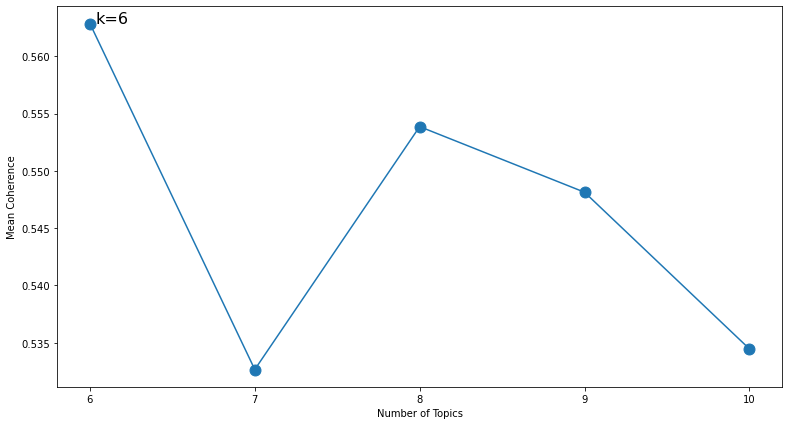

In [20]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [21]:
final_n = k_values[coherences.index(max(coherences))]
    
print("Best num_topics =", final_n)

# Define Search Param
search_params = {'n_components': [final_n], 'learning_decay': [.5, .6, .7, .8, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tweet_vecs)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Params= ", model.best_params_)

Best num_topics = 6
Best Params=  {'learning_decay': 0.8, 'n_components': 6}


In [22]:
tweet_lda = LatentDirichletAllocation(n_components = final_n,               # Number of topics
                                  learning_method='online',   
                                  n_jobs = -1,
                                   learning_decay = model.best_params_['learning_decay'])              # use all available CPU
lda_output = tweet_lda.fit_transform(tweet_vecs)

# Log Likelyhood: Higher the better
print("\nLog Likelihood: ", tweet_lda.score(tweet_vecs))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", tweet_lda.perplexity(tweet_vecs))

# See model parameters
pprint(tweet_lda.get_params())


Log Likelihood:  -9538741.665897194
Perplexity:  2816.4865706851424
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.8,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 6,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


Topic 0:
science care anthrax job problem symptom health freedom home system morning hope worker support side
Topic 1:
arm folk test work money government company mom player employee policy trump story syringe matter
Topic 2:
kid risk friend fact doctor population choice country family wear patient school group study effect
Topic 3:
mandate flu issue state place question datum country restriction age health news baxter omicron government
Topic 4:
virus trucker side_effect variant infection chance help hospital protection treatment team bed reaction staff nurse
Topic 5:
booster death child case hospital rate trust reason pandemic hospitalization body spread disease adult end


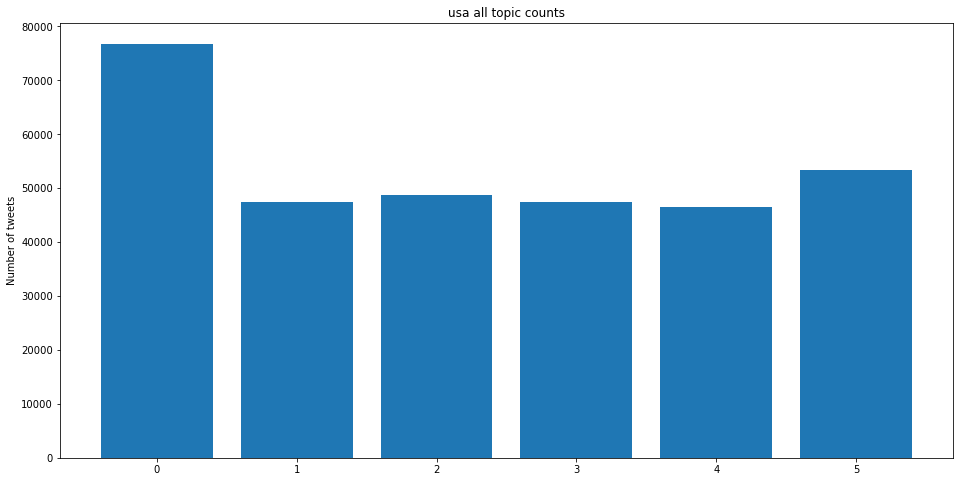

In [23]:
# Write a function to display the topics and for each topic we choose the top most frequent words. 

no_top_words = 15
display_topics(tweet_lda, feature_names, no_top_words)

lda_keys = get_keys(lda_output)
lda_categories, lda_counts = keys_to_counts(lda_keys)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_ylabel('Number of tweets');
ax.set_title("usa all" + ' topic counts');
plt.show()

In [24]:
# Set up the environment to display the graphical outputs
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Generate the visuals
visual = pyLDAvis.sklearn.prepare(tweet_lda, tweet_vecs, vectorizer, mds='tsne')

# Save the output|to the html file
pyLDAvis.save_html(visual, "usa_noun.html")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogethe